<a href="https://colab.research.google.com/github/jazcar1205/AIStoryGenerator/blob/main/MADEMiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mini Project: Implement ARM or LVM

Model chosen: MADE ( Masked Autoencoder for Distribution Estimation.

Topic: Satellite Image Analysis for Damage Assessment: Generate pre- and post-disaster satellite images to assess damages automatically

Dataset: xView2 Challenge Training set


In [ ]:
import os
import glob
import json
import torch
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from google.colab import drive
drive.mount('/content/drive')

IMAGES_PATH = '/content/drive/MyDrive/TrainingSet/images'

SPLIT = ''


NUM_COMPONENTS = 5
OUTPUT_PIXEL_DIM = 3 * NUM_COMPONENTS
NUM_HIDDEN_LAYERS = 4
HIDDEN_SIZE = 1024
NUM_WORKERS = 0
PATCH_SIZE = 32
IMAGE_BANDS = 3
INPUT_DIM = PATCH_SIZE * PATCH_SIZE * IMAGE_BANDS * 2
NUM_COMPONENTS = 5  # K=5 Gaussian components
OUTPUT_PIXEL_DIM = 3 * NUM_COMPONENTS  # (mean, log_std, mixing_weight) * K
MADE_OUTPUT_DIM = INPUT_DIM * OUTPUT_PIXEL_DIM

Using device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

IMAGES_PATH = '/content/drive/MyDrive/TrainingSet/images'

print("--- First 5 image files in your directory ---")
try:
    # Use os.listdir to get all file names in the directory
    all_files = os.listdir(IMAGES_PATH)

    # Filter to only get the first 5 entries
    for i, filename in enumerate(all_files):
        if i < 5:
            # Print the actual file name found on disk
            print(filename)
        else:
            break

    if not all_files:
        print(f"Error: The directory {IMAGES_PATH} appears to be empty.")

except FileNotFoundError:
    print(f"Error: The directory {IMAGES_PATH} was not found. Check the path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- First 5 image files in your directory ---
socal-fire_00000552_post_disaster.png
socal-fire_00000593_pre_disaster.png
socal-fire_00000553_post_disaster.png
socal-fire_00000576_pre_disaster.png
socal-fire_00000585_pre_disaster.png


In [ ]:
class XView2RawDataIndexer (Dataset):
    """
    Indexer: Finds paired pre/post image paths and calculates a fixed center crop.
    Damage labels and JSON files are entirely ignored.
    """
    def __init__(self, image_dir, label_dir=None, patch_size=32):
        # NOTE: label_dir is now optional but kept for compatibility.
        self.patch_size = patch_size
        self.samples = []
        self.image_dir = image_dir
        self.half_p = self.patch_size // 2

        # 1. Find all PRE-DISASTER image files (not JSONs)
        # Use recursive search to handle possible subfolders
        image_files = glob.glob(os.path.join(self.image_dir, '**', '*_pre_disaster.png'), recursive=True)

        for pre_image_path in tqdm(image_files, desc="Indexing Image Patches"):

            # Construct the corresponding POST-DISASTER image path
            post_filename = os.path.basename(pre_image_path).replace('_pre_disaster.png', '_post_disaster.png')

            # ASSUMING: post image is in the same directory as pre image
            post_image_path = os.path.join(os.path.dirname(pre_image_path), post_filename)

            # Skip if image pair is missing
            if not os.path.exists(post_image_path):
                continue

            try:
                # Load PRE image just to get its size (needed for center crop)
                temp_img = Image.open(pre_image_path)
                img_width, img_height = temp_img.size
                temp_img.close()
            except Exception:
                continue # Skip corrupted images

            # --- Simplified Crop Box Calculation (Center of Image) ---
            # NOTE: This replaces the building-centric polygon logic entirely.

            # Calculate the center of the full image
            center_x, center_y = img_width // 2, img_height // 2

            # Calculate crop box centered on the image
            crop_left = max(0, center_x - self.half_p)
            crop_top = max(0, center_y - self.half_p)
            crop_right = min(img_width, center_x + self.half_p)
            crop_bottom = min(img_height, center_y + self.half_p)

            # Final check: skip if patch size is zero or too small
            if (crop_right - crop_left) != self.patch_size or \
               (crop_bottom - crop_top) != self.patch_size:
                # This should only happen if the source image is too small
                continue

            # Append sample with fixed center crop box
            self.samples.append({
                'pre_path': pre_image_path,
                'post_path': post_image_path,
                'crop_box': (crop_left, crop_top, crop_right, crop_bottom),
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Implementation is in XView2MADETransformDataset, which inherits this
        raise NotImplementedError("Use the XView2MADETransformDataset subclass.")


class XView2MADETransformDataset(XView2RawDataIndexer):
    """
    Transforms image patches into a single, flattened MADE input vector.
    Vector structure: [Flatten(Pre-Patch), Flatten(Post-Patch)]
    """
    def __init__(self, image_dir, label_dir=None, transform=None, patch_size=32):
        # Note: label_dir is now ignored in the super() call
        super().__init__(image_dir, label_dir, patch_size)
        # Use simple ToTensor() transformation
        self.transform = transform if transform else transforms.ToTensor()

    def __getitem__(self, idx):
        sample = self.samples[idx]
        crop_left, crop_top, crop_right, crop_bottom = sample['crop_box']

        # Load and Crop Images
        pre_img = Image.open(sample['pre_path']).convert('RGB')
        post_img = Image.open(sample['post_path']).convert('RGB')

        pre_patch = pre_img.crop((crop_left, crop_top, crop_right, crop_bottom))
        post_patch = post_img.crop((crop_left, crop_top, crop_right, crop_bottom))

        # Resize patch if needed (shouldn't be needed with center crop, but keep as safety)
        if pre_patch.size != (self.patch_size, self.patch_size):
            pre_patch = pre_patch.resize((self.patch_size, self.patch_size))
            post_patch = post_patch.resize((self.patch_size, self.patch_size))

        # Convert to Tensor (scales to [0, 1]) and Flatten
        pre_patch_tensor = self.transform(pre_patch).float()
        post_patch_tensor = self.transform(post_patch).float()

        # FINAL MADE INPUT VECTOR: [Flatten(Pre-Patch), Flatten(Post-Patch)]
        x_made = torch.cat([pre_patch_tensor.flatten(), post_patch_tensor.flatten()])

        return x_made

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

# --- 1. NEW CONSTANT ---
NUM_COMPONENTS = 5  # Number of Gaussian components (K=5 is common)

# The output dimension must be K * 3 for each pixel:
# (INPUT_DIM/2) pixels * 3 parameters * K components
OUTPUT_PIXEL_DIM = 3 * NUM_COMPONENTS
TOTAL_OUTPUT_DIM = (INPUT_DIM // 2) * OUTPUT_PIXEL_DIM
# The full MADE output is P(X_pre, X_post), so it must predict the full vector,
# but only the X_post pixels use MoG parameters.
# We'll stick to INPUT_DIM * 3 * K for simplicity and mask the loss.
MADE_OUTPUT_DIM = INPUT_DIM * OUTPUT_PIXEL_DIM


# --- 2. MOLECULAR SAMPLING FUNCTION (Replaces the old made_sample_post_disaster) ---
def made_sample_mog(model, pre_patch_tensor, patch_size, image_bands, device):
    """
    Generates X_post by sequential sampling from the MoG distribution
    predicted by MADE, conditioned on X_pre.
    """
    model.eval()

    pre_flat = pre_patch_tensor.flatten().to(device)
    post_flat_len = patch_size * patch_size * image_bands

    # Initialize the full MADE vector: [X_pre (known), X_post (unknown/zeros)]
    x_made = torch.cat([pre_flat, torch.zeros(post_flat_len, device=device)])

    start_index = post_flat_len

    with torch.no_grad():
        for i in range(start_index, start_index + post_flat_len):
            # Output contains the MoG parameters for all D dimensions
            output = model(x_made.unsqueeze(0))

            # --- Extract MoG parameters for the current pixel i ---
            # The output vector is [D_1_params, D_2_params, ..., D_D_params]
            # Each D_i_params is (3 * K) long
            pixel_index_in_output = i - (INPUT_DIM // 2)

            # Index into the second half of the output vector (P_post)
            param_start = pixel_index_in_output * OUTPUT_PIXEL_DIM
            param_end = param_start + OUTPUT_PIXEL_DIM
            params = output[0, param_start:param_end]

            # --- Decompose and Sample ---

            # 1. Mixing Weights (pi) - logits -> probabilities
            pi_logits = params[0*NUM_COMPONENTS : 1*NUM_COMPONENTS]
            pi_probs = F.softmax(pi_logits, dim=0)

            # 2. Means (mu)
            mu = params[1*NUM_COMPONENTS : 2*NUM_COMPONENTS]

            # 3. Log-Scales (log_sigma) -> standard deviations
            log_sigma = params[2*NUM_COMPONENTS : 3*NUM_COMPONENTS]
            sigma = torch.exp(log_sigma)

            # Select a component based on pi
            component_index = torch.multinomial(pi_probs, 1).item()

            # Sample from the selected Gaussian
            sampled_mean = mu[component_index]
            sampled_std = sigma[component_index]

            # Add small noise to enforce sampling (standard N(mu, sigma) sampling)
            sampled_value = sampled_mean + sampled_std * torch.randn(1, device=device)

            # Set the sampled value back into the input vector for the next step.
            x_made[i] = sampled_value.clamp(0, 1) # Clamp to [0, 1] range

    # Extract and Reshape the Generated X_post
    generated_post_flat = x_made[start_index:]
    generated_post_patch = generated_post_flat.reshape(image_bands, patch_size, patch_size)

    return generated_post_patch.cpu()


# --- 3. MOLECULAR LOSS FUNCTION (Replaces the old MSE Loss) ---
# --- GLOBAL CONSTANTS (REQUIRED FOR LOSS FUNCTION) ---

def log_prob_mog(x, pi_logits, mu, log_sigma):
    """Calculates the log-probability of data x under the MoG distribution."""

    # Expand x to match mu/sigma dimensions (Batch, D, K)
    x = x.unsqueeze(-1).expand_as(mu)

    # Calculate log(N(x | mu, sigma))
    log_probs = -0.5 * torch.log(2 * torch.pi * torch.ones_like(log_sigma))
    log_probs -= log_sigma
    log_probs -= 0.5 * ((x - mu) / torch.exp(log_sigma))**2

    # Calculate log P(x) = log( sum_k (exp(log(pi_k) + log P(x | component=k))) )
    log_pi = F.log_softmax(pi_logits, dim=-1)
    log_conditional = log_pi + log_probs

    # LogSumExp trick
    log_p_x = torch.logsumexp(log_conditional, dim=-1)

    # Negative Log-Likelihood (NLL) Loss: -log P(x)
    return -log_p_x


def MoG_loss(output, target):
    """
    Calculates the Negative Log-Likelihood (NLL) loss for the MADE model.
    Only computes loss on the X_post half of the vector (P(X_post | X_pre)).
    """
    batch_size = target.size(0)
    data_dim = target.size(1)

    # Reshape the MADE output: (Batch, D * (3*K)) -> (Batch, D, 3, K)
    # The output dimension is now 3*K times the input dimension.
    output = output.reshape(batch_size, data_dim, 3, NUM_COMPONENTS)

    # Decompose parameters: (Batch, D, K)
    pi_logits = output[:, :, 0, :]
    mu = output[:, :, 1, :]
    log_sigma = output[:, :, 2, :]

    # Clamp log_sigma to prevent numerical instability during exp()
    log_sigma = torch.clamp(log_sigma, min=-7.0, max=3.0)

    # Calculate the log-probability for every dimension (pixel) in the batch
    log_probs_per_dim = log_prob_mog(target, pi_logits, mu, log_sigma)

    # We only care about the X_post half of the vector (P(X_post | X_pre))
    post_half_start = data_dim // 2

    # Loss is the mean of the sum of NLL over all X_post dimensions
    # .sum(dim=1) sums over all pixels in X_post. .mean() averages over the batch.
    loss = log_probs_per_dim[:, post_half_start:].sum(dim=1).mean()

    return loss, loss.item() # Return tensor and scalar loss

In [ ]:
class MaskedLinear(nn.Linear):
    """
    A Linear layer with an applied mask to enforce the autoregressive property.
    This class remains unchanged from your original implementation.
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.copy_(mask)

    def forward(self, input):
        return F.linear(input, self.weight * self.mask, self.bias)


class MADE(nn.Module):
    """
    Masked Autoencoder for Distribution Estimation, upgraded to output
    Mixture of Gaussian (MoG) parameters.
    """
    def __init__(self, input_dim=INPUT_DIM, hidden_size=HIDDEN_SIZE,
                 num_hidden_layers=NUM_HIDDEN_LAYERS, activation='relu'):
        super().__init__()

        # Output is now the global MoG dimension
        self.input_dim = input_dim
        self.output_dim = MADE_OUTPUT_DIM  # <-- CRITICAL CHANGE
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers

        activation_map = {'relu': nn.ReLU(), 'tanh': nn.Tanh()}
        self.activation = activation_map[activation]

        layers = []
        # Input layer
        layers.append(MaskedLinear(self.input_dim, self.hidden_size))
        layers.append(self.activation)

        # Hidden layers
        for _ in range(self.num_hidden_layers - 1):
            layers.append(MaskedLinear(self.hidden_size, self.hidden_size))
            layers.append(self.activation)

        # Output layer (now targets the MoG dimension)
        layers.append(MaskedLinear(self.hidden_size, self.output_dim))

        self.net = nn.Sequential(*layers)
        self.m = {}
        self.d = {}
        self.initialize_masks()

    def initialize_masks(self):
        """Initializes the masks (M) and dependency vectors (m) for all layers."""
        L = self.num_hidden_layers + 1

        # 1. Define input/output connectivity vector (m_k)
        self.m[0] = torch.arange(self.input_dim, device=device) # Input connectivity

        # Hidden Layer connectivity (k=1 to L-1) - UNCHANGED
        for l in range(1, L):
            min_prev = torch.min(self.m[l-1]).item()
            max_prev = torch.max(self.m[l-1]).item()
            self.m[l] = torch.randint(min_prev, max_prev + 1, (self.hidden_size,), device=device)

        # Output layer connectivity (m_L): CRITICAL CHANGE
        # Each output unit (3*K parameters) must depend only on input units with a SMALLER index.
        # Original pixel indices: [0, 1, 2, ..., 6143]
        pixel_indices = torch.arange(self.input_dim, device=device)
        # Repeat each pixel index (3*K) times: [0,0,0..., 1,1,1..., 6143,6143,...]
        # This ensures all parameters for pixel i depend on i-1 or less.
        self.m[L] = pixel_indices.repeat_interleave(OUTPUT_PIXEL_DIM)


        # 2. Compute and set masks (M_k) - Logic remains the same, using new m[L]
        layers = [l for l in self.net if isinstance(l, MaskedLinear)]

        for l in range(L):
            mask = torch.zeros(self.m[l+1].shape[0], self.m[l].shape[0], device=device)

            # Input and Hidden Layers (l < L-1)
            if l < L - 1:
                # M_l(i, j) = 1 if m_l(i) >= m_{l-1}(j)
                for i in range(self.m[l+1].shape[0]):
                    for j in range(self.m[l].shape[0]):
                        if self.m[l+1][i] >= self.m[l][j]:
                            mask[i, j] = 1
            # Output Layer (l = L-1)
            else:
                # M_L(i, j) = 1 if m_L(i) > m_{L-1}(j) (Strict inequality)
                for i in range(self.m[l+1].shape[0]):
                    for j in range(self.m[l].shape[0]):
                        if self.m[l+1][i] > self.m[l][j]:
                            mask[i, j] = 1

            # Set the mask on the corresponding linear layer
            layers[l].set_mask(mask)

    def forward(self, x):
        return self.net(x)

In [ ]:
# Instantiate the dataset
print("Starting data indexing...")
# --- CHANGE: Removed label_dir argument ---
full_dataset = XView2MADETransformDataset(
    image_dir=IMAGES_PATH,
    # label_dir=LABELS_PATH, # <-- REMOVED
    patch_size=PATCH_SIZE
)
# -------------------------------------------

total_samples = len(full_dataset)
print(f"\n✅ Total building samples loaded for training: {total_samples}")

if total_samples > 0:
    # Define split sizes
    # NOTE: Ensure 'random_split' is imported from torch.utils.data
    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size

    # Split the dataset
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    print(f"Training Samples: {len(train_dataset)}")
    print(f"Validation Samples: {len(val_dataset)}")

    # Create DataLoaders
    BATCH_SIZE = 64
    NUM_WORKERS = 0 # Set to 0 for Colab/Notebook environments to avoid multiprocessing issues

    # NOTE: Ensure 'DataLoader' is imported from torch.utils.data
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print("\nDataLoaders created successfully.")
else:
    print("\n🛑 Cannot proceed: No samples were loaded. Double-check image paths and the file search logic.")


try:
    made_model = MADE(
        input_dim=INPUT_DIM,
        hidden_size=HIDDEN_SIZE,
        num_hidden_layers=NUM_HIDDEN_LAYERS
    ).to(device)

    print("\n--- MADE MoG Model Summary ---")
    print(f"Model instantiated with {NUM_HIDDEN_LAYERS} hidden layers.")
    print(f"Total parameters: {sum(p.numel() for p in made_model.parameters()):,}")
    print(f"Final Output Layer Size (MoG): {made_model.output_dim}")

except NameError:
    print("\n🛑 ERROR: The 'MADE' class or 'MaskedLinear' class is not defined. Please ensure you ran the cell defining the MADE MoG architecture.")

Starting data indexing...


Indexing Image Patches: 100%|██████████| 2799/2799 [01:22<00:00, 34.01it/s] 



✅ Total building samples loaded for training: 2799
Training Samples: 2239
Validation Samples: 560

DataLoaders created successfully.


In [ ]:
# --- Training Function Structure (UPDATED) ---
def train_made(model, loader, optimizer, num_epochs):
    """
    Trains the MADE MoG model using Negative Log-Likelihood loss.
    """
    model.train()

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0

        if loader is None:
            print("🛑 WARNING: Data Loader is None. Skipping training loop definition.")
            break

        for batch_idx, data in enumerate(tqdm(loader, desc=f"Epoch {epoch}/{num_epochs}")):

            data = data.to(device)

            optimizer.zero_grad()

            output = model(data)

            # Calculate loss (NOW USING MoG_loss)
            # MoG_loss returns: (total_loss_tensor, total_loss_scalar)
            total_loss, avg_loss_scalar = MoG_loss(output, data) # <-- FIXED LINE

            total_loss.backward()
            optimizer.step()

            running_loss += avg_loss_scalar

        avg_loss = running_loss / len(loader)
        print(f"Epoch {epoch} Complete. Avg Total Loss (NLL): {avg_loss:.4f}")

train_made(made_model, train_loader, optimizer, NUM_EPOCHS)

Epoch 1/20: 100%|██████████| 35/35 [09:44<00:00, 16.69s/it]


Epoch 1 Complete. Avg Total Loss: 0.1056


Epoch 2/20: 100%|██████████| 35/35 [04:04<00:00,  6.99s/it]


Epoch 2 Complete. Avg Total Loss: 0.0557


Epoch 3/20: 100%|██████████| 35/35 [03:52<00:00,  6.66s/it]


Epoch 3 Complete. Avg Total Loss: 0.0339


Epoch 4/20: 100%|██████████| 35/35 [03:54<00:00,  6.71s/it]


Epoch 4 Complete. Avg Total Loss: 0.0251


Epoch 5/20: 100%|██████████| 35/35 [03:58<00:00,  6.80s/it]


Epoch 5 Complete. Avg Total Loss: 0.0211


Epoch 6/20: 100%|██████████| 35/35 [03:49<00:00,  6.55s/it]


Epoch 6 Complete. Avg Total Loss: 0.0179


Epoch 7/20: 100%|██████████| 35/35 [03:57<00:00,  6.79s/it]


Epoch 7 Complete. Avg Total Loss: 0.0158


Epoch 8/20: 100%|██████████| 35/35 [03:50<00:00,  6.58s/it]


Epoch 8 Complete. Avg Total Loss: 0.0143


Epoch 9/20: 100%|██████████| 35/35 [03:46<00:00,  6.48s/it]


Epoch 9 Complete. Avg Total Loss: 0.0134


Epoch 10/20: 100%|██████████| 35/35 [04:04<00:00,  6.97s/it]


Epoch 10 Complete. Avg Total Loss: 0.0125


Epoch 11/20: 100%|██████████| 35/35 [03:50<00:00,  6.58s/it]


Epoch 11 Complete. Avg Total Loss: 0.0119


Epoch 12/20: 100%|██████████| 35/35 [03:48<00:00,  6.53s/it]


Epoch 12 Complete. Avg Total Loss: 0.0114


Epoch 13/20: 100%|██████████| 35/35 [04:08<00:00,  7.11s/it]


Epoch 13 Complete. Avg Total Loss: 0.0111


Epoch 14/20: 100%|██████████| 35/35 [03:46<00:00,  6.48s/it]


Epoch 14 Complete. Avg Total Loss: 0.0107


Epoch 15/20: 100%|██████████| 35/35 [03:56<00:00,  6.75s/it]


Epoch 15 Complete. Avg Total Loss: 0.0104


Epoch 16/20: 100%|██████████| 35/35 [03:48<00:00,  6.54s/it]


Epoch 16 Complete. Avg Total Loss: 0.0101


Epoch 17/20: 100%|██████████| 35/35 [03:57<00:00,  6.78s/it]


Epoch 17 Complete. Avg Total Loss: 0.0099


Epoch 18/20: 100%|██████████| 35/35 [03:58<00:00,  6.83s/it]


Epoch 18 Complete. Avg Total Loss: 0.0096


Epoch 19/20: 100%|██████████| 35/35 [03:48<00:00,  6.52s/it]


Epoch 19 Complete. Avg Total Loss: 0.0094


Epoch 20/20: 100%|██████████| 35/35 [03:57<00:00,  6.78s/it]

Epoch 20 Complete. Avg Total Loss: 0.0092


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def made_sample_post_disaster(model, pre_patch_tensor, patch_size, image_bands, device):
    """
    Generates the post-disaster patch (X_post) by sampling from the MADE model
    conditioned on the pre-disaster patch (X_pre).

    Since MADE is an autoregressive model P(x_1, ..., x_D), we feed the first
    half (X_pre) and sequentially sample the second half (X_post).
    """
    model.eval()

    # 1. Prepare the input vector X: [X_pre, X_post(zeros)]
    # X_pre is the input conditioning. It must be flattened.
    pre_flat = pre_patch_tensor.flatten().to(device)

    # X_post is initially a vector of zeros/unknowns.
    post_flat_len = patch_size * patch_size * image_bands

    # Initialize the full MADE vector: [X_pre (known), X_post (unknown/zeros)]
    # We use a copy of the pre_flat to start.
    x_made = torch.cat([pre_flat, torch.zeros(post_flat_len, device=device)])

    # 2. Sequential Sampling Loop
    # The output dimension (D) is the full vector length (INPUT_DIM).
    # We only need to sample indices corresponding to X_post (the second half).

    start_index = post_flat_len # Start index of X_post pixels

    # Iterate through every pixel dimension in X_post
    with torch.no_grad():
        for i in range(start_index, start_index + post_flat_len):
            # The current partial vector is used to predict the next pixel value.
            # We predict the entire vector, but only use the i-th prediction.

            # MADE outputs logits/means for each output dimension
            output = model(x_made.unsqueeze(0))

            # For continuous data (MSE loss), the MADE output is treated as the predicted mean.
            # We use this predicted mean as the sample (since we trained with MSE).
            predicted_value = output[0, i]

            # Set the predicted value back into the input vector for the next step.
            x_made[i] = predicted_value

    # 3. Extract and Reshape the Generated X_post
    # The generated post-disaster vector is the second half of x_made
    generated_post_flat = x_made[start_index:]

    # Reshape: (C, H, W) -> (3, 32, 32)
    generated_post_patch = generated_post_flat.reshape(image_bands, patch_size, patch_size)

    return generated_post_patch

def visualize_samples(pre_patch_tensor, generated_post_tensor, original_post_tensor=None):
    """Visualizes the pre-disaster, generated, and optionally the original post-disaster patches."""

    # Ensure tensors are on CPU and convert to image format (C, H, W)
    pre_patch = pre_patch_tensor.cpu()
    generated_post = generated_post_tensor.cpu().clamp(0, 1) # Clamp to [0, 1] range

    images = [pre_patch, generated_post]
    titles = ["Pre-Disaster (Input)", "Generated Post-Disaster"]

    if original_post_tensor is not None:
        images.append(original_post_tensor.cpu())
        titles.append("Original Post-Disaster (Ground Truth)")

    fig, axes = plt.subplots(1, len(images), figsize=(5 * len(images), 5))

    if len(images) == 1:
        axes = [axes] # Ensure axes is iterable for a single image case

    for ax, img, title in zip(axes, images, titles):
        # Convert tensor (C, H, W) to image format (H, W, C)
        img_np = img.permute(1, 2, 0).numpy()
        ax.imshow(img_np)
        ax.set_title(title, fontsize=14)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Indexing Image Patches: 100%|██████████| 2799/2799 [01:35<00:00, 29.41it/s] 


Total Validation Samples: 560

Starting Autoregressive Sampling...


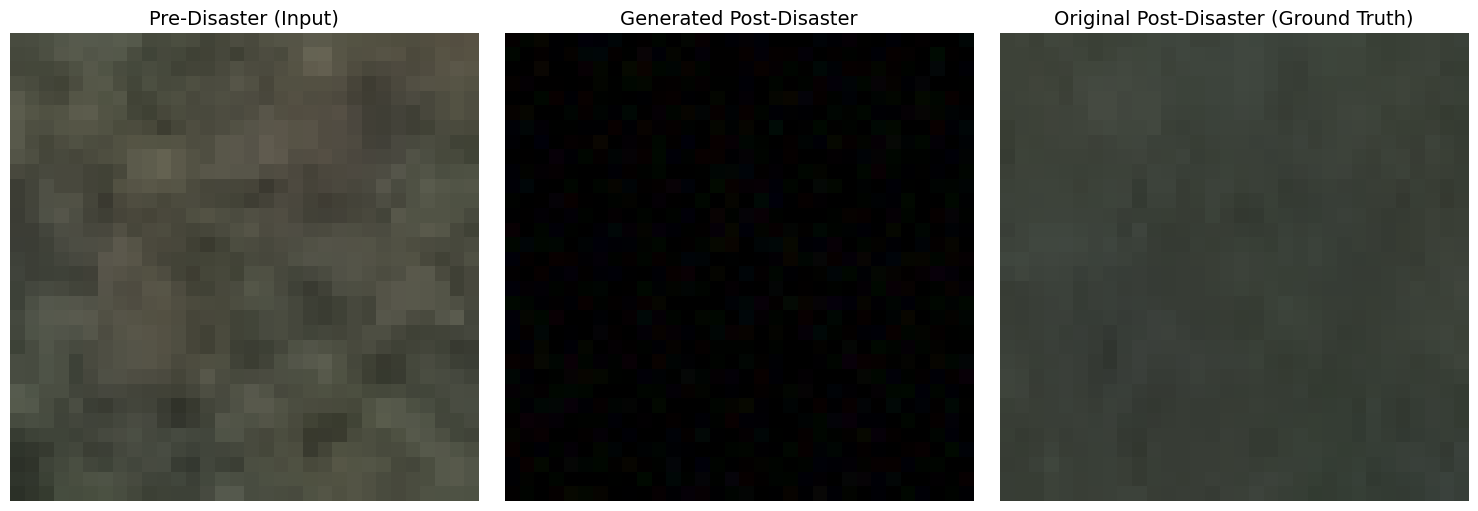


Generated image displayed above. The goal is for the 'Generated Post-Disaster' image to closely resemble the 'Original Post-Disaster' image.


In [ ]:
# --- 1. Load Data ---
# Instantiate the full dataset (uses the XView2MADETransformDataset defined earlier)
full_dataset = XView2MADETransformDataset(image_dir=IMAGES_PATH, patch_size=PATCH_SIZE)
total_samples = len(full_dataset)

# Split sizes from your training run [cite: 308-310]
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# NOTE: The training split used here must match the split used for training the model.
# Ensure 'random_split' is imported (already handled in section 1).
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Total Validation Samples: {len(val_dataset)}")

# --- 2. Instantiate and Load Model ---
made_model = MADE(
    input_dim=INPUT_DIM,
    hidden_size=HIDDEN_SIZE,
    num_hidden_layers=NUM_HIDDEN_LAYERS,
    output_dim=OUTPUT_DIM
).to(device)

# --- 3. Run Inference on a Sample ---

# Get a sample from the validation set (e.g., the 5th sample)
test_sample_idx = 4
test_sample_vector = val_dataset[test_sample_idx]

# --- Extract Pre and Post Patches (for Ground Truth comparison) ---
# The MADE vector is [Flattened Pre-Patch, Flattened Post-Patch]
pixel_count = PATCH_SIZE * PATCH_SIZE * IMAGE_BANDS
pre_flat_ground_truth = test_sample_vector[:pixel_count]
post_flat_ground_truth = test_sample_vector[pixel_count:]

# Reshape to (C, H, W)
pre_patch_tensor = pre_flat_ground_truth.reshape(IMAGE_BANDS, PATCH_SIZE, PATCH_SIZE)
original_post_tensor = post_flat_ground_truth.reshape(IMAGE_BANDS, PATCH_SIZE, PATCH_SIZE)


# --- GENERATE THE POST-DISASTER IMAGE ---
print("\nStarting Autoregressive Sampling...")

# The MADE model is now used to sample the post-disaster image
generated_post_patch = made_sample_post_disaster(
    model=made_model,
    pre_patch_tensor=pre_patch_tensor,
    patch_size=PATCH_SIZE,
    image_bands=IMAGE_BANDS,
    device=device
)

# --- 4. Visualize Results ---
visualize_samples(pre_patch_tensor, generated_post_patch, original_post_tensor)
print("\nGenerated image displayed above. The goal is for the 'Generated Post-Disaster' image to closely resemble the 'Original Post-Disaster' image.")